# Assignment 2: Gibbs Sampling and Metropolis-Hastings


STATS305C, Stanford University, Spring 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw2/hw2.ipynb)



---

**Name: Isaac KM** 

**Collaborators: Saskia C.** 

---



In this homework assignment, we will investigate a hierarchical Bayesian model of polling data. To perform inference, we will implement a hybrid Gibbs/Metropolis-Hastings sampler.

### Background: Polling Data

The 2004 election between George W. Bush and John Kerry was closely contested. Both campaigns focused heavily on the swing state of Ohio, worth 20 votes in the electoral college. CNN/USA Today/Gallup conducted several Ohio polls in the months leading up to the election on November 4th, and obtained the following raw results:

|   | Kerry | Bush | Total
| :- | :- | :- | :- |
| Sept. 4-7 | 284 | 344 | 628 |
| Sept. 25-28 | 312 | 325 | 637 |
| Oct. 17-20 | 346 | 339 | 685 |
| Oct. 28-31 | 556 | 511 | 1067 |

The polling data can be found [here](http://www.cnn.com/ELECTION/2004/special/president/showdown/OH/) (although there are some dead links on the page).

We will let $\{x_i\}_{i = 1}^4$ denote the number of votes for Kerry in each poll, and let $\{n_i\}_{i = 1}^4$ denote the total number surveyed in each poll. We will represent these quantities in code using integer PyTorch tensors.

In [ ]:
import torch
from torch.distributions import Gamma, Beta, Binomial, Normal
torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

In [ ]:
xs = torch.tensor([284., 312., 346., 556.]) #, dtype=int)
ns = torch.tensor([628., 637., 685., 1067.]) #, dtype=int)


### Background: Hierarchical Model

It is reasonable to model each voter's support as a draw from a Bernoulli distribution, with some poll-specific probability $\rho_i$ of supporting Kerry. We believe each poll has a different probability since the polls are conducted at different times and may reach different subpopulations of voters (e.g. if one is conducted over telephone and another is an internet survey). However, these $\rho_i$ are likely highly correlated due to a base level of support for Kerry in the general population. We will therefore use the following model: 

\begin{align}
\rho_i &\sim \mathrm{Beta}(\alpha, \beta) \quad  \text{for } i =1, \ldots, 4 \\ 
x_i \mid \rho_i &\sim \mathrm{Bin}(\rho_i, n_i) \quad  \text{for } i =1, \ldots, 4
\end{align}
Note that the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is a conjugate prior for the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). (See also, Bishop Ch. 2.1.)

Following a Bayesian approach, we introduce priors over the parameters $\alpha$ and $\beta$. Unfortunately, the parameters of the beta distribution do not have a simple conjugate prior. Instead, we will assume $\alpha$ and $\beta$ follow gamma distributions, resulting in the following Bayesian hierarchical model.
\begin{align}
\alpha &\sim \mathrm{Ga}(c_\alpha, d_\alpha) \\
\beta &\sim \mathrm{Ga}(c_\beta, d_\beta) \\
\rho_i \mid \alpha, \beta &\sim \mathrm{Beta}(\alpha, \beta) \quad  \text{for } i =1, \ldots, 4 \\ 
x_i \mid \rho_i &\sim \mathrm{Bin}(\rho_i, n_i) \quad  \text{for } i =1, \ldots, 4
\end{align}

Here, $c_\alpha, d_\alpha, c_\beta, d_\beta$ are fixed hyperparameters for the "hyper-priors" on $\alpha$ and $\beta$ and we use the shape-rate parametrization of the gamma distribution. 

How should we interpret these hyperparameters? Recall that in a beta-Bernoulli model we can interpret the parameters of the beta as pseudo-observations. That is, we can view $\alpha$ and $\beta$ as results from a prior poll that resulted in $\alpha$ voters for Kerry and $\beta$ voters for Bush. Thus, we can interpret the mean of $\alpha$ as previously observed supporters for Kerry and its standard deviation as a measure of uncertainty in this number of previous voters.

Since the mean of $\alpha$ is $\frac{c_\alpha}{d_\alpha}$ and the standard deviation is $\sqrt{\frac{c_\alpha}{d_\alpha^2}}$, and similarly for $\beta$, we can adjust the hyperparameters to accord with our prior belief on Kerry/Bush's level of support.

### Problem 1 [Math]: Derive the complete conditional for $\rho$ 

In order to implement a Gibbs sampler, we must be able to sample from the complete conditional of each of the unobserved variables in our model. We will sample the variables $\rho = (\rho_1, \dots, \rho_4)$ simultaneously as part of a [*block Gibbs update*](https://en.wikipedia.org/wiki/Gibbs_sampling#Blocked_Gibbs_sampler). 

#### Part (a): Demonstrate conditional independence of $\{\rho_i\}$

First, show that we have:

$$p(\rho \mid \alpha, \beta, \{x_i\}) = \prod_{i=1}^4 p(\rho_i \mid \alpha, \beta, x_i)$$





---
First, observe
\begin{align*}
p(\{\rho_i\}|\alpha, \beta, \{x_i\}, \ldots )
&\propto 
p(\{\rho_i\},\alpha, \beta, \{x_i\}, \ldots )\\
&=
\bigg(
\prod_{i=1}^4 Binom(x_i | \rho_i, n_i) Beta(\rho_i | \alpha, \beta)
\bigg)Gamma(\alpha|c_\alpha, d_\alpha)Gamma(\beta|c_\beta, d_\beta)&\propto 
p(\{\rho_i\},\alpha, \beta, \{x_i\}, \ldots )\\
& \propto
\bigg(
\prod_{i=1}^4 Binom(x_i | \rho_i, n_i) Beta(\rho_i | \alpha, \beta)
\bigg).
\end{align*}

We also have, for a single $j$, that:
\begin{align*}
p(\rho_j|\alpha, \beta, \{x_i\}, \ldots )
&\propto 
p(\{\rho_i\},\alpha, \beta, \{x_i\}, \ldots )\\
&=
\bigg(
\prod_{i=1}^4 Binom(x_i | \rho_i, n_i) Beta(\rho_i | \alpha, \beta)
\bigg)Gamma(\alpha|c_\alpha, d_\alpha)Gamma(\beta|c_\beta, d_\beta)&\propto 
p(\{\rho_i\},\alpha, \beta, \{x_i\}, \ldots )\\
& \propto
\bigg(
\prod_{i=1}^4 Binom(x_i | \rho_i, n_i) Beta(\rho_i | \alpha, \beta)
\bigg) \\
&\propto 
Binom(x_j | \rho_j, n_j) Beta(\rho_j | \alpha, \beta).
\end{align*}

Hence, omitting integrating constants, we see that

$$
p(\{\rho_i\},\alpha, \beta, \{x_i\}, \ldots )
\propto \prod_{i=1}^4 p(\rho_j|\alpha, \beta, \{x_i\}, \ldots ),
$$
giving conditional independence, as we are only off by a constant not dependent on the relevant parameters. 

---

#### Part (b): 

Fixing $i$, derive the conditional density of $\rho_i$ given $\alpha, \beta, x_i$, that is, compute:
$$p(\rho_i \mid \alpha, \beta, x_i)$$

Hint: Remember that this conditional density is proportional to the joint density of all the variables. The density should simplify nicely to a known density.

---
This amounts to a standard beta-binomial conjugacy:
\begin{align*}
p(\rho_i | \alpha, \beta, x_i) 
&
\propto 
p(\rho_i, x_i, \alpha, \beta, \ldots) \\
&
\propto 
Binom(x_i | \rho_i, n_i) \cdot Beta(\rho_i | \alpha, \beta) \\
&
\propto 
\left(\rho_i^{x_i}(1 - \rho_i)^{n_i - x_i}\right)\left(\rho_i^{\alpha - 1}(1 - \rho_i)^{\beta - 1}\right)\\
&
\propto 
\rho_i^{x_i  + \alpha - 1}(1 - \rho_i)^{n_i - x_i + \beta - 1} \\
&\sim Beta(x_i + \alpha, n_i - x_i + \beta).
\end{align*}

---

### Problem 2: Write code to sample from the complete conditional for $\rho$

Write a function which generates a sample from the conditional distribution for $\rho$ given $\alpha$, $\beta$, and $\{x_i, n_i\}$.

In [ ]:
from torch.distributions import Beta

def gibbs_sample_rhos(alpha, beta, xs, ns):
    """
    Returns a sample from the complete conditional of \{\rho_i\} given alpha, 
    beta, and \{x_i, n_i\}.

    Args:
        alpha: scalar value > 0
        beta: scalar value > 0
        xs, ns: the data
    Returns:
        rhos: torch.tensor of length 4 with values in [0,1]
    """
    return Beta(alpha + xs, ns - xs + beta).sample()

### Problem 3: Derive and implement the complete conditional for $\alpha$

#### Part (a): Derive the complete conditional

Next, we need to derive the complete conditional for the global variables $\alpha$ and $\beta$. We will first find the complete conditional of $\alpha$. As usual, you should use that the conditional density is proportional to the joint density to find this conditional. However, unlike earlier, the conditional density is not of a simple, known form. Instead, you should find an expression for the conditional density up to an unknown normalizing constant, i.e. an expression that the conditional density is proportional to, up to a constant.

---
_Your answer here_.

\begin{align*}
p(\alpha |-)
&=
L(\{\rho_i, x_i\}, \alpha, \beta, ...) \\
&\propto 
\bigg(\prod_{i=1}^4 Beta(\rho_i| \alpha, \beta)\bigg) Gamma(\alpha | c_\alpha, d_\alpha) \\
&\propto 
\bigg(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}\prod_{i=1}^4 \rho_i ^{\alpha - 1} (1 - \rho_i)^{\beta-1}\bigg)
\alpha^{c_\alpha - 1}\exp(-d_\alpha \alpha) \\
&\propto 
\bigg(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\bigg)^4
\bigg(\prod_{i=1}^4 \rho_i \bigg)^{\alpha}
\alpha^{c_\alpha - 1}\exp(-d_\alpha \alpha).
\end{align*}
Hence,
$$
\log p(\alpha |-)
=
4(\log \Gamma(\alpha + \beta) - \log \Gamma(\alpha)) + 
\alpha \sum_{i=1}^4\log \rho_i + (c_\alpha - 1)\log \alpha 
-d_\alpha \alpha
$$



---

#### Part (b): Write code evaluating the unnormalized log probability

By taking the logarithm of your answer above, we have an expression for the log conditional density, up to an additive constant. Implement this expression below in code.

Hint: You may find the Pytorch function ```lgamma``` useful.

In [ ]:
def alpha_log_cond(alpha, beta, rhos, c_alpha, d_alpha):
    """
    Returns log p(\alpha \mid \beta, \{\rho_i\}, \{x_i\})
    Args:
        alpha: scalar value > 0
        beta: scalar value > 0
        rhos: torch.tensor of length 4 with values in [0,1]
        c_alpha: scalar value > 0
        d_alpha: scalar value > 0
    Returns:
        log_cond: scalar, conditional log probability of alpha
    """
    K = rhos.shape[0]
    log_cond = (
        K * (torch.lgamma(alpha + beta) - torch.lgamma(alpha))
        + alpha * torch.sum(torch.log(rhos))
        + (c_alpha - torch.tensor(1.)) * torch.log(alpha)
        - d_alpha * alpha
    )
    return log_cond

### Problem 4: Derive and implement the complete conditional for $\beta$

#### Part (a): Derive the complete conditional

Write down an expression for the complete conditional density of $\beta$, up to a normalizing constant. Your expression should be very similar to the expression for $\alpha$ in problem 3(a). You do not need to show your work.

---
_Your answer here._

Here, we just sub $\beta$ for $\alpha$ above, and deal with $1 - \rho_i$ instead. That is,

\begin{align*}
p(\alpha |-)
&=
L(\{\rho_i, x_i\}, \alpha, \beta, ...) \\
&\propto 
\bigg(\prod_{i=1}^4 Beta(\rho_i| \alpha, \beta)\bigg) Gamma(\beta | c_\beta, d_\beta) \\
&\propto 
\bigg(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}\prod_{i=1}^4 \rho_i ^{\alpha - 1} (1 - \rho_i)^{\beta-1}\bigg)
\beta^{c_\beta - 1}\exp(-d_\beta \beta) \\
&\propto 
\bigg(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\bigg)^4
\bigg(\prod_{i=1}^4 (1 - \rho_i) \bigg)^{\beta}
\beta^{c_\beta - 1}\exp(-d_\beta \beta).
\end{align*}
Hence,
$$
\log p(\alpha |-)
=
4(\log \Gamma(\alpha + \beta) - \log \Gamma(\beta)) + 
\beta \sum_{i=1}^4\log \rho_i + (c_\beta - 1)\log \beta
-d_\beta \beta
$$

---

#### Part (b): Write code evaluating the unnormalized log probability

As in 3(b), write a function which evaluates the log complete conditional for $\beta$, up to an additive constant. This should be very similar to your function from 3(b).

In [ ]:
def beta_log_cond(alpha, beta, rhos, c_beta, d_beta):
    """
    Returns log p(\beta \mid \alpha, \{\rho_i\}, \{x_i\})
    Args:
        alpha: scalar value > 0
        beta: scalar value > 0
        rhos: torch.tensor of length 4 with values in [0,1]
        c_beta: scalar value > 0
        d_beta: scalar value > 0
    Returns:
        log_cond: scalar, conditional log probability of beta
    """
    K = rhos.shape[0]
    log_cond = (
        K * (torch.lgamma(alpha + beta) - torch.lgamma(beta))
        + beta * torch.sum(torch.log(torch.tensor(1.) - rhos))
        + (c_beta - torch.tensor(1.)) * torch.log(beta)
        - d_beta * beta
    )
    return log_cond

### Problem 5: Write code to sample from the complete conditionals for $\alpha$ and $\beta$

Because we only know the complete conditionals for $\alpha$ and $\beta$ up to a normalizing constant, we will use the Metropolis-Hastings algorithm to sample from them. We will use a normal distribution centered at our current point as the proposal distribution. We will use the same standard deviation for the proposals of $\alpha$ and $\beta$. Thus, the proposal distributions will be:
\begin{align}
q(\alpha \mid \alpha') &= \mathcal{N}(\alpha ; \alpha', l^2) \\
q(\beta \mid \beta') &= \mathcal{N}(\beta ; \beta', l^2)
\end{align}
for some $l > 0$.

Note that we require $\alpha > 0$ and $\beta > 0$, so we may make a proposal which lies outside the support of the complete conditional. You should convince yourself that there is zero probability of accepting such a proposal in the Metropolis algorithm. 

Implement a step of the Metropolis-Hastings algorithm for both $\alpha$ and $\beta$ in the function below. You will have to use ```alpha_log_cond``` and ```beta_log_cond``` which you implemented above. 

_Hint_: You may find ```torch.rand``` useful for simulating uniform random variables, or ```torch.distributions.Bernoulli``` for sampling binary random variables with specified probabilities.

In [ ]:
def mh_step_alpha_beta(alpha, beta, rhos, c_alpha, d_alpha, c_beta, d_beta, l=20.):
    """
    Performs a MH step for both alpha and beta.
    Args:
        alpha, beta, rhos: current values of these random variables
        c_alpha, d_alpha, c_beta, d_beta: hyperparameters
        l: standard deviation of proposal distribution
    Returns:
        new_alpha, new_beta: new values of alpha and beta after MH step
    """
    proposal_dist_alpha = Normal(alpha, l)
    new_alpha = proposal_dist_alpha.sample()

    # If proposal is negative, we can reject immediately.
    if new_alpha < 0:
        new_alpha = alpha
    # Otherwise, we must check the accept-reject condition.
    else:
        # raw accept ratio
        log_accept_ratio_alpha = (
            alpha_log_cond(new_alpha, beta, rhos, c_alpha, d_alpha) # P(x')
            + proposal_dist_alpha.log_prob(alpha) # g(x|x') RE-USING proposal_dist by symmetry
            # for non-symmetric, we'd need a reversal dist (downhill/uphill)
            - alpha_log_cond(alpha, beta, rhos, c_alpha, d_alpha) # P(x)
            - proposal_dist_alpha.log_prob(new_alpha) # g(x'|x) 
        )
        # truncate
        log_accept_ratio_alpha = torch.minimum(log_accept_ratio_alpha, torch.tensor(0.))
        # take the draw 
        u_alpha = torch.distributions.Uniform(0., 1.).sample()
        if u_alpha > torch.exp(log_accept_ratio_alpha): 
            new_alpha = alpha
    
    proposal_dist_beta = Normal(beta, l)
    new_beta = proposal_dist_beta.sample()
    # If proposal is negative, we can reject immediately.
    if new_beta < 0:
        new_beta = beta
    # Otherwise, we must check the accept-reject condition.
    else:
        # raw accept ratio
        log_accept_ratio_beta = (
            beta_log_cond(alpha, new_beta, rhos, c_beta, d_beta) # P(x')
            + proposal_dist_beta.log_prob(beta) # g(x|x') RE-USING proposal_dist by symmetry
            # for non-symmetric, we'd need a reversal dist (downhill/uphill)
            - beta_log_cond(alpha, beta, rhos, c_beta, d_beta) # P(x)
            - proposal_dist_beta.log_prob(new_beta) # g(x'|x) 
        )
        # truncate
        log_accept_ratio_beta = torch.minimum(log_accept_ratio_beta, torch.tensor(0.))
        # take the draw 
        u_beta = torch.distributions.Uniform(0., 1.).sample()
        if u_beta > torch.exp(log_accept_ratio_beta): 
            new_beta = beta
    return new_alpha, new_beta

### Problem 6: Implement a Gibbs sampler

Using ```mh_step_alpha_beta``` and ```sample_rhos```, implement a Gibbs sampler for the proposed model. 

Using the generated samples, we will estimate the posterior mean and standard deviation of $\rho_1, \dots, \rho_4$, and $\frac{\alpha}{\alpha + \beta}$. The latter quantity represents the base level of support for Kerry in the broader population, and is of particular interest for who will win the election.

We will also track the joint log-probability of our sample throughout the iterations of the sampler. This will be useful as a diagnostic tool to check whether our sampler is correctly implemented. To easily evaluate the joint probability in code, we recommend making use of the `torch.distributions` imported above.

In [ ]:
from tqdm import trange
rhos_0 = xs / ns
def gibbs(n_iter,
          xs,
          ns,
          alpha=torch.tensor(10.),
          beta=torch.tensor(10.),
          rhos=rhos_0,
          c_alpha=torch.tensor(6.25), 
          d_alpha=torch.tensor(0.025),
          c_beta=torch.tensor(6.25),
          d_beta=torch.tensor(0.025),
          burn_in=0.5):
    """
    Performs Gibbs sampling in the Bayesian hierarchical model of polling data.
    Args:
        n_iter: number of iterations of Gibbs sampling
        xs, ns: the data
        alpha, beta, rhos: initial values of these random variables
        c_alpha, d_alpha, c_beta, d_beta: hyperparameters
        burn_in: fraction of samples to discard before computing expectations
    Returns:
        rhos_mean, rhos_std: posterior mean and standard deviation of rhos
        prob_mean, prob_std: posterior mean and standard deviation of alpha/(alpha+beta)
        lps: torch tensor of size 'n_iter' containing log joint probabilities.
    """
    rhos_samples = []
    prob_samples = []
    alpha_samples = []
    beta_samples = []
    lps = torch.zeros(n_iter)

    for it in trange(n_iter):
        # Resample alpha, beta using a single Metropolis-Hastings step.   
        alpha, beta = mh_step_alpha_beta(alpha, beta, rhos, c_alpha, d_alpha, c_beta, d_beta, l=20.)

        # Resample rhos using the complete conditional.
        rhos = gibbs_sample_rhos(alpha, beta, xs, ns)
        # update the trace
        if it > n_iter * burn_in:
            rhos_samples += [rhos]
            prob_samples += [alpha / (alpha + beta)]
            alpha_samples += [alpha]
            beta_samples += [beta]

        # Evaluate log-joint probability at current sample
        lps[it] = (
            # likelihood
            torch.sum(Binomial(ns, rhos).log_prob(xs))
            # priors 
            + torch.sum(Beta(alpha, beta).log_prob(rhos))
            # hyperpriors 
            + Gamma(c_alpha, d_alpha).log_prob(alpha) 
            + Gamma(c_beta, d_beta).log_prob(beta) 
        )

    rhos_samples = torch.stack(rhos_samples)
    prob_samples = torch.stack(prob_samples)
    rhos_mean, rhos_std = torch.mean(rhos_samples, axis=0), torch.std(rhos_samples, axis=0)
    prob_mean, prob_std = torch.mean(prob_samples), torch.std(prob_samples)

    return dict(
        rhos_samples=rhos_samples,
        prob_samples=prob_samples,
        alpha_samples=alpha_samples,
        beta_samples=beta_samples,
        rhos_mean=rhos_mean,
        rhos_std=rhos_std,
        prob_mean=prob_mean,
        prob_std=prob_std,
        lps=lps,
    )

### Problem 7: Model Diagnostics

Run Gibbs sampling for 10000 iterations (this should take about 15 seconds to run). Use the default values provided in the function signature. Plot the evolution of the joint-log-probability over iterations. 

In [ ]:
# Run Gibbs sampling for 10000 iterations
trace = gibbs(100000, xs, ns, burn_in=.25)

100%|██████████| 100000/100000 [04:13<00:00, 393.71it/s]


Above, sampling is run under default configurations; I then plot traces of $\alpha, \beta$, as well as $\{\rho_i\}$, to check for convergence. Lastly, the trace of log-density is plotted. In general, I am satisfied with convergence, at least from afar.

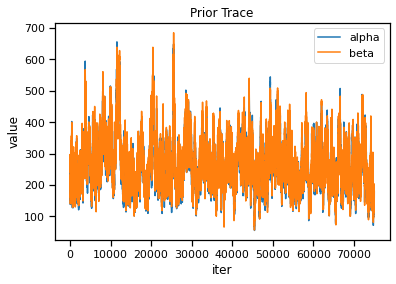

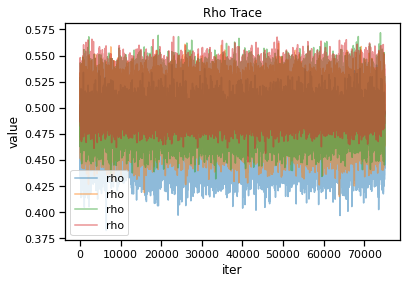

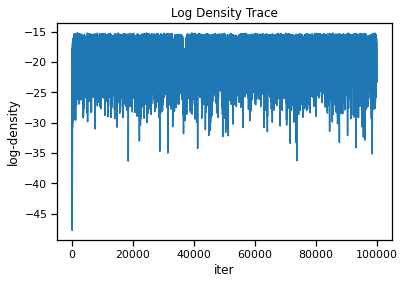

In [ ]:
plt.plot(trace["alpha_samples"], label="alpha")
plt.plot(trace["beta_samples"], label="beta")
plt.legend()
plt.xlabel("iter")
plt.ylabel("value")
plt.title("Prior Trace")
plt.show()


plt.plot(trace["rhos_samples"], label="rho", alpha=.5)
plt.legend()
plt.xlabel("iter")
plt.ylabel("value")
plt.title("Rho Trace")
plt.show()

plt.plot(trace["lps"])
plt.xlabel("iter")
plt.ylabel("log-density")
plt.title("Log Density Trace")
plt.show()

### Problem 7: Investigations

#### Part (a):

What are the posterior means and standard deviations for $\rho_1, ..., \rho_4$ and $\frac{\alpha}{\alpha + \beta}$? Do these results seem reasonable to you?

In [ ]:
# Print the posterior means and standard deviations.
print("Mean Rhos: ", trace["rhos_mean"].numpy())
print("SD Rhos:   ", trace["rhos_std"].numpy())
print("Mean (a / (a + B): ", trace["prob_mean"].numpy())
print("SD (a / (a + B):   ", trace["prob_std"].numpy())

Mean Rhos:  [0.47087336 0.49169135 0.5003881  0.5123641 ]
SD Rhos:    [0.01733812 0.01693571 0.01651157 0.01406655]
Mean (a / (a + B):  0.49394837
SD (a / (a + B):    0.019108813


---
Posterior values of $\rho_i$ are printed in the first row above; they seem to indicate increasing support for Kerry (recall a 1 is a Kerry vote) from September through October. However, the underlying mean is still < .5, suggesting some general amount of support for Bush. And given that Kerry eventually lost with around 48% of the vote, this mean $\alpha / (\alpha + \beta)$ at least passes the smell test.

Moreover, we also see a decrease in the posterior (sampled) variance of $\rho_4$ (as compared to $\rho_1, \rho_2, \rho_3$), which aligns with intuition -- the fourth poll had the largest sample size, and hence we would expect a lower variance there. It's reassuring to see this replicated, albeit to a lesser extent, reflected in the posterior.

---

#### Part (b):

Find a setting of the hyperparameters $c_\alpha, d_\alpha, c_\beta, d_\beta$ which will result in a prior that heavily favors Kerry. Re-run the Gibbs sampler with these settings. What is the new mean and standard deviation for $\frac{\alpha}{\alpha + \beta}$?

In order to have a prior that heavily favors Kerry, we will want a prior structure that makes $\alpha$ comparatively larger than $\beta$; one way to do this is to parameterize the $\Gamma(c_\alpha, d_\alpha)$ such that it has a large mean. To this end, consider $\alpha \sim \Gamma(625, .025)$, but keeping the default/original $\beta\sim \Gamma(6.25, .025)$. 

In [ ]:
# Run Gibbs sampling with new hyperparameters and print the posterior mean and 
# standard deviation.
trace_kerry = gibbs(100000, xs, ns, burn_in=.25, c_alpha=torch.tensor(625.))

100%|██████████| 100000/100000 [04:06<00:00, 405.99it/s]


Log-density trace is as follows:

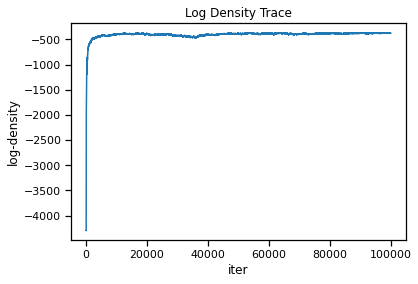

In [ ]:
plt.plot(trace_kerry["lps"])
plt.xlabel("iter")
plt.ylabel("log-density")
plt.title("Log Density Trace")
plt.show()

And posterior means/SDs are:

In [ ]:
# Print the posterior means and standard deviations.
print("Mean Rhos: ", trace_kerry["rhos_mean"].numpy())
print("SD Rhos:   ", trace_kerry["rhos_std"].numpy())
print("Mean (a / (a + B): ", trace_kerry["prob_mean"].numpy())
print("SD (a / (a + B):   ", trace_kerry["prob_std"].numpy())

Mean Rhos:  [0.56812406 0.5692132  0.5695341  0.56917644]
SD Rhos:    [0.02240472 0.02240113 0.02236203 0.02196845]
Mean (a / (a + B):  0.5716946
SD (a / (a + B):    0.022831064


---

Indeed and not unexpectedly, our updated/more extreme/more informative/less realistic prior choice moves the posterior more in favor of Kerry. It's also worth noting that under this prior, the log density is lower than above, reflecting the outrageousness of the prior.

---

### Problem 8: Reflections

#### Part (a):

Describe a setting in which a Gibbs sampler will be slow to mix. Why might our parametrization of the beta distribution in terms of $\alpha$, $\beta$ slow down the Gibbs sampler? Can you think of a different parametrization which would work better?

---
First, we might be able to speed things up by choosing a conjugate prior (see the final cell [here](https://en.wikipedia.org/wiki/Conjugate_prior)) -- since we do not have conjugacy under this current configuration, we have to take an M-H step to update $\alpha, b\eta$. This involves more evaluation of (often ugly) log densities, as well as inevitable slowing due to the M-H's "rejection gate" procedure. If we had access to the conjugate prior (which again, is only defined up to proportionality), we could do a proper Gibbs step, accept every move, and perhaps speed things up. This is, however, a comparatively less impactful fix. 

Second, and more importantly, $\alpha$ and $\beta$ are almost assuredly correlated, which may inhibit the sampler's ability to explore the space. For intuition why they're correlated, consider the following: $\alpha$ represents strength of Kerry support, $\beta$ represents strength of Bush support, and thus $\alpha / ($\alpha + \beta)$ represents fraction of Kerry support. However, when Kerry support increases, Bush support most likely decreases; hence, there is some degree of correlation between the two. As such, we might want to consider alternative parameterizations that avoid this trap. Among them, we could parameterize:

1.) the mean and variance of Kerry support, e.g. a mean and/or variance directly from which to draw $\rho_i$. In this way, we'd be parameterizing mean and variance of Kerry support explicitly, and hence Bush support implicitly. More precisely, you could parameterize mean and variance Kerry support via a Gaussian or T, and transform via method-of-moments to the appropriate Beta. That is, you would model some prior

$$
\mu \sim g(N(\mu_0, \sigma^2_0))
$$
and 
$$
\sigma^2 \sim \Lambda(\theta_0)
$$
for some positive-supported prior $\Lambda(\theta_0)$ (e.g. exponential, gamma, inverse chi-squared, etc.). Additionally, $g$ is some transformation to ensure $\mu \in (0, 1)$, e.g. a sigmoid or Gaussian CDF (Probit). At this point, you'd have a deterministic (think method of moments) mean and variance for your beta, and would proceed with 
$$
\rho_i \sim Beta(\alpha_\beta(\mu, \sigma^2), \beta_\beta(\mu, \sigma^2)),
$$
where $\alpha_\beta(\mu, \sigma^2), \beta_\beta(\mu, \sigma^2)$ guarantee that the beta has the desired mean and variance. 

2.) Alternatively, and perhaps more practically, we might want to just parameterize the $\beta$ prior via 
\begin{align*}
\eta_1 &\sim \Gamma(\cdot)\\
\eta_2 &\sim \Gamma(\cdot),
\end{align*}
and then go
$$
\rho_i \sim \beta(\eta_1, \eta_1\eta_2). 
$$
This will have
mean
$$
\frac{\eta_1}{\eta_1 + \eta_2 \eta_2} = \frac{1}{1 + \eta_2}
$$
and variance (unsimplified)
$$
\frac{\eta_1^2\eta_2}{(\eta_1 + \eta_1\eta_2)^2(\eta_1 + \eta_1\eta_2 + 1)}.
$$
In this way, $\eta_2$ would effectively define the mean, while $\eta_1, \eta_2$ in conjunction would give you the variance. Of course, the $\Gamma$ prior could be swapped for any other non-negative density; $\Gamma$ is just a natural choice. 


---

#### Part (b):

Describe one way in which a Markov Chain using a Metropolis-Hastings adjusted transition may be slow to mix. Which variable in the code above could be tuned in order to speed up convergence?

---

With the M-H sampler, you'll likely run into a Goldilocks issue with the proposal distribution (here, both for $\alpha, \beta$): make proposals too aggressive/unreasonable (i.e. large $l$) and you'll always reject and stay in place, but make proposals too conservative (i.e. small $l$) and you won't meaningfully move and explore . So it may be difficult find this appropriate balance, i.e. the best $l$ to use.

Moreover, as we did above, the proposal distribution may generate proposals that fall off the support of the variable of interest, as was the auto-reject case above for $\alpha < 0$ or $\beta < 0$. So selecting a proposal distribution that won't waste time proposing impossible values may be another M-H tuning parameter that deserves considerable attention, lest the model suffer slow mixing.

---

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and remove the Open in Colab button.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourname>_hw1.ipynb
```


**Installing nbconvert:**

If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope. 